## Atari Breakout Q-Learning

##### Allow memory growth for tensorflow, Windows work around

import tensorflow as tf  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
session = tf.Session(config=config)  

##### Verify GPU availability

from tensorflow.python.client import device_lib  
print(device_lib.list_local_devices())  
from keras import backend as K  
print(K.tensorflow_backend._get_available_gpus())  

#### Training

In [1]:
from ai_image_preprocess import preprocess
import ai_state as state_util

def step(env, action, state):
    next_frame_1, reward_1, done_1, _ = env.step(action)
    next_frame_2, reward_2, done_2, _ = env.step(action)
    next_state = state_util.update(state, preprocess(next_frame_1), preprocess(next_frame_2))
    return (next_state, int(reward_1 + reward_2), done_1 or done_2)

In [2]:
import ai_display as display
import ai_state as state_util
from ai_logger import Logger
import time

def train(env, agent, n_episodes=10000, model_name="model", save_interval=50):
    logger = Logger(10, "episode | frames | score | step time | epi time")
    
    for episode in range(n_episodes):
        
        frame = env.reset()
        state = state_util.create(preprocess(frame))
        score = 0
        
        start_time = time.time()
        for t in range(5000):
            display.show_state(state, env.spec.id, t, score)

            action = agent.act(state)
            next_state, reward, done = step(env, action, state)
            agent.remember(state, action, reward, next_state, done)
            agent.replay(batch_size=32)
            
            state = next_state
            score += reward
            
            if done: 
                break
                
        duration = time.time() - start_time
        logger.log("{:>7d} | {:>6d} | {:>5d} | {:>9.5f} | {:>8.5f}"
               .format(episode+1, t, score, duration/t, duration))
                
        if episode % save_interval == 0:
            agent.save_model(model_name)
        
    agent.save_model(model_name)
        

#### Main

In [3]:
def calc_dimensions(env):
    n_actions = env.action_space.n
    obs_shape = env.observation_space.shape
    height = obs_shape[0]//2; width = obs_shape[1]//2; n_frames = 4
    state_shape = (height, width, n_frames)
    return (state_shape, n_actions)

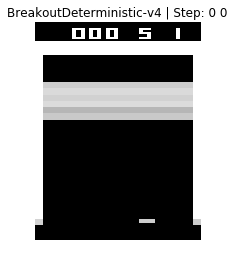

In [ ]:
from ai_agent import Agent
import gym

env = gym.make("BreakoutDeterministic-v4")
state_shape, n_actions = calc_dimensions(env)

agent = Agent(state_shape, n_actions, epsilon=0.4)

model_name = "models/laptop-model.h5"
#agent.new_model()
agent.load_model(model_name) 
train(env, agent, model_name=model_name)
